<a href="https://colab.research.google.com/github/yufengg/jax-in-action/blob/master/JAX_in_Action_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Setup

## Change to GPU runtime
* Select the dropdown next to the "Connect" button
* Select "Change runtime type"
* Select "T4 GPU"

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp

from jax import random

# Speeding up numpy with `jit()`

Helper function that creates 2 arrays:
- 1 numpy
- 1 jax

In [ ]:
def create_arrays(dims):
  x_np = np.random.normal(size=dim).astype(np.float32)
  x_jax = jax.random.normal(jax.random.PRNGKey(0), shape=dim, dtype=jnp.float32)
  return x_np, x_jax

In [ ]:
dim = (3_000, 3_000)
x_np, x_jax = create_arrays(dim)

In [ ]:
x_np.shape

(3000, 3000)

In [ ]:
x_jax.shape

(3000, 3000)

Do a matrix multiply with itself, `X*X`, using jax and numpy

In [ ]:
%timeit -n5 jnp.matmul(x_jax, x_jax).block_until_ready() # block_until_ready() is needed to properly time the operation, because jax executes async

The slowest run took 27.88 times longer than the fastest. This could mean that an intermediate result is being cached.
61.7 ms ± 119 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
%timeit -n5 np.matmul(x_np, x_np) # this will take a bit of time

805 ms ± 83 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Create an arbitrary math function, and run a np array through vs a jax array:

`y = 3x^3 + 2x^2 + x`

Let's up the array size 10x

In [ ]:
def my_func(x):
  return 3*x*x*x + 2*x*x + x

In [ ]:
dim = (10000, 10000)
x_np, x_jax = create_arrays(dim)

In [ ]:
%timeit -n5 my_func(x_np)

611 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
%timeit -n5 my_func(x_jax).block_until_ready()

33.8 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Can we do better? Yes, with the power of `jit()`!

`jax.jit()` uses 'just in time' compliation to further optimize the operations.

In [ ]:
jit_func = jax.jit(my_func)

In [ ]:
%timeit -n5 jit_func(x_jax).block_until_ready()

4.71 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## JIT Tracing

How does `jit()` lead to such performance improvements?



# `vmap()` for batching

automatic vectorization:
- define a function on a vector. `vmap()` will generate a batched version using matrices, instead of using a for-loop.

In [ ]:
key = jax.random.PRNGKey(42) # because 42 is the answer

In [ ]:
W = jax.random.normal(key, (64, 100), dtype=jnp.float32)
# 16 batches of input, each batch contains 100 elements
batch_x = jax.random.normal(key, (16, 100), dtype=jnp.float32)

W.shape, batch_x.shape

((64, 100), (16, 100))

## Using dot products to compute a matrix multiply

A dot product can be computed for a matrix times a vector

In [ ]:
# Compute dot-product for the first input of the batch (out of 16)
x = batch_x[0]
W.shape, x.shape

((64, 100), (100,))

In [ ]:
y = jnp.dot(W, x)

In [ ]:
y.shape

(64,)

but a matrix dot-product with another matrix fails, because W is 64x100, and batch_x is 16x100

In [ ]:
# y = jnp.dot(W, batch_x) # this does not work

We could compute this using a for loop, going over the first-dimension of batch_x (e.g. batch_x[0] , batch_x[1], ..., batch_x[15])

Clever users of dot products will note that we can fix this problem by simply taking the transpose, so that the dimensions line up as 64x100 and 100x16

In [ ]:
y = jnp.dot(W, batch_x.T) # this works
y.shape

(64, 16)

But wait, did it actually work? Don't we want 16 rows of 64 values each?

Okay, let's another transpose after the dot product...

In [ ]:
y = jnp.dot(W, batch_x.T).T
y.shape

(16, 64)

What if a single function call could save us all that hassle of figuring out which terms needed to be transposed to make this work?

In [ ]:
y_vmap = jax.vmap(jnp.dot, in_axes=(None, 0))(W, batch_x) # in_axes=(None, 0) means "vectorize the 0-index dimension of the 2nd arg"
y_vmap.shape

(16, 64)

The shapes match, yes... but values should also match, right?

In [ ]:
assert y.all() == y_vmap.all()

# Automatic `grad()`ient calculation

Use `grad(f)` to create a (new) function that returns gradients of `f`.

Useful in (not only) machine learning.

In [ ]:
from jax import grad

## Linear functions

In [ ]:
# Remember y= mx + b ? (Here the M is upside down as a W, for "weight")

def linear_func(x, w, b):
  y = w * x + b
  return y

In [ ]:
x = 4.0
w = 3.0
b = 2.0

linear_func(x,w,b) # y = 3x + 2 | x=4

14.0

In [ ]:
dydx = grad(linear_func)(x,w,b) # derivative y = 3x + 2, wrt x, is 3
dydx

Array(3., dtype=float32, weak_type=True)

`argnums=1` to take a derivative with respect to `w`, the 2nd arg (index=1)

of `y = w * x + b`

is `x`, whose value is 4



In [ ]:
dw = grad(linear_func, argnums=1)(x,w,b)
dw

Array(4., dtype=float32, weak_type=True)

You can get all the derivatives by passing in multiple values to argnums

In [ ]:
dx, dw, db = grad(linear_func, argnums=(0,1,2))(x,w,b)
dx, dw, db

(Array(3., dtype=float32, weak_type=True),
 Array(4., dtype=float32, weak_type=True),
 Array(1., dtype=float32, weak_type=True))

Remember that grad is _creating a new function_ to compute these gradients. That's why we still need to pass in the values of `x,w,b` each time.

# Neural Network with `jax.numpy`

* Create a function that initializes a single fully-connected layer with random values
* Create a handful of layers
* `predict()` function (forward pass)
* `loss()` function to define the error to optimize
  * this is what we "optimize" with `grad()`.
* `update()` the NN parameters based in the direction `grad` gives us

## Create network layers

In [ ]:
# note that we return W and b together as an ordered pair
def init_layer(key, n_in, n_out):
  k1, k2 = random.split(key)
  W = random.normal(k1, (n_in, n_out))
  b = random.normal(k2, (n_out,))
  return W, b

In [ ]:
# Given a list of layer_sizes, create the corresponding matrices
def create_layers(key, layer_sizes):
  key, *keys = random.split(key, len(layer_sizes))
  params = list(map(init_layer, keys, layer_sizes[:-1], layer_sizes[1:]))
  return params

In [ ]:
layer_sizes = [1, 40, 20, 1]
key = random.PRNGKey(0)
params = create_layers(key, layer_sizes)

## Create input and outputs

so we have data to test with

In [ ]:
# inputs and targets are the X and y that we are trying to train
inputs = np.random.normal(size = (256,1))

# y = 3x^3 + 5x^2 + 9x + 2 + some noise
x = inputs
targets = 3*x*x*x + 5*x*x + 9*x + 2 + np.random.normal(size=(256,1), scale = 1.5)

In [ ]:
# Shows the shapes of the nested arrays.
jax.tree.map(lambda x: x.shape, params)

# we can pass other lambda functions to map other operations to the parameters of our model.
# Inputs to map() are a lambda function followed by the inputs to that lambda function

[((1, 40), (40,)), ((40, 20), (20,)), ((20, 1), (1,))]

## Predict function

Wire together layer parameters and inputs to produce network output.

In [ ]:
def predict(params, X):
  *hidden, last = params # separate the last layer from the rest, because we don't need an activation func for that one

  for W, b in hidden:
    X = jax.nn.relu(jnp.matmul(X, W) + b) # need to update this RELU call to be NNX

  # the last layer does not get relu'd
  W, b = last
  return jnp.matmul(X, W) + b

In [ ]:
predict(params, inputs)

Array([[-9.4722545e-01],
       [ 2.1858722e-02],
       [-2.5506160e+00],
       [-2.6042132e+00],
       [ 1.8392056e-02],
       [-2.5034542e+00],
       [ 3.3762343e+00],
       [ 2.2361958e+00],
       [-1.2270550e+00],
       [ 2.4831016e+00],
       [-1.0141662e+00],
       [ 5.2394986e+00],
       [-2.1930606e+00],
       [-3.3171889e-01],
       [-7.4683022e-01],
       [-2.5995541e+00],
       [-2.8265383e+00],
       [-3.3367065e-01],
       [ 2.0327793e+01],
       [ 2.5558487e+01],
       [-4.4484763e+00],
       [ 7.9954820e+00],
       [-1.0412807e+00],
       [ 6.6769519e+00],
       [ 3.8140099e+01],
       [ 8.9899645e+00],
       [ 1.9395357e+01],
       [ 2.3597057e+00],
       [ 1.3845015e+01],
       [-2.5351837e+00],
       [ 6.4385085e+00],
       [-1.0626311e+00],
       [-3.0498207e-03],
       [-2.7116315e+00],
       [-2.6595647e+00],
       [ 2.4138715e+00],
       [-8.5357368e-01],
       [ 5.0074420e+00],
       [ 6.5318376e-02],
       [ 1.0987531e+01],


## Create loss and update functions

Compute the error (loss) of the current prediction, and compute the gradient to use in `update()`

In [ ]:
# mean squared error
def loss(params, X, y):
  return jnp.mean((predict(params, X) - y)**2)

In [ ]:
loss(params, inputs, targets)

Array(620.65625, dtype=float32)

In [ ]:
# use grad() to compute the gradient of the loss wrt to the parameters of the model
def update(params, X, y, lr):
  g = grad(loss)(params, X, y)
  # update each parameter by subtracting the (learning rate x gradient)
  return jax.tree.map(lambda params, g: params - lr*g, params, g)

In [ ]:
update(params, inputs, targets, 1e-2)

[(Array([[ 0.5685796 ,  1.7817302 ,  1.161634  ,  0.66253954,  0.2243501 ,
          -0.41830313,  0.3960202 , -0.9290872 ,  0.9190633 , -1.7914038 ,
          -0.30728495, -0.18219772, -2.5158265 ,  1.4966128 , -1.1494813 ,
           1.8447098 ,  0.7113078 ,  0.6153676 , -0.00976264, -1.2366883 ,
           1.6674768 ,  0.5785488 , -0.43796965,  1.6589642 , -1.3621253 ,
           0.10718459,  0.481996  ,  0.73571074,  0.04824607,  1.7095363 ,
           1.2181575 ,  0.4788201 , -0.28886396, -2.2996876 , -1.0662405 ,
           2.202159  , -2.3985083 ,  1.0163707 ,  1.1475047 ,  1.769851  ]],      dtype=float32),
  Array([-0.24255285,  1.2427988 , -1.5067512 , -0.8578976 , -0.76659447,
          2.1076236 ,  0.4767879 ,  1.3392878 ,  1.1243875 , -0.7910228 ,
         -1.1025404 , -0.8633722 ,  1.5090855 , -2.0582304 , -1.2756615 ,
          1.0560006 ,  1.0481668 , -0.38627714,  0.62931144, -0.6310521 ,
          0.985658  , -1.048042  , -1.2198635 ,  0.9767535 ,  1.6375947 ,
       

## Train and plot

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def train_model(params, x, y, lr):
  loss_history = []

  for i in range(3000):
    # compute loss value for plotting and debug purposes only
    loss_val = loss(params, x, y)
    loss_history.append(loss_val)
    if (i%300) == 0:
      print(f"Loss at step {i}: {loss_val}")

    # perform the training update
    params = jax.jit(update)(params, x, y, lr)

  plt.plot(loss_history)
  return params

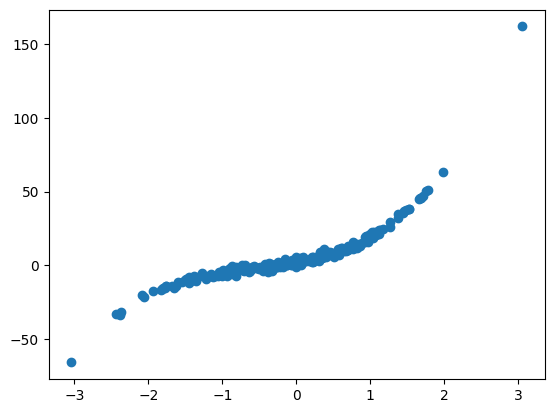

In [ ]:
# inputs and targets are the X and y that we are trying to train
inputs = np.random.normal(size = (256,1))

# y = 3x^3 + 5x^2 + 9x + 2 + some noise
x = inputs
targets = 3*x*x*x + 5*x*x + 9*x + 2 + np.random.normal(size=(256,1), scale = 1.5)

plt.scatter(inputs, targets)

Loss at step 0: 600.421875
Loss at step 300: 40.11406326293945
Loss at step 600: 22.633411407470703
Loss at step 900: 16.82077407836914
Loss at step 1200: 13.520671844482422
Loss at step 1500: 11.741966247558594
Loss at step 1800: 10.331432342529297
Loss at step 2100: 9.15040111541748
Loss at step 2400: 8.106636047363281
Loss at step 2700: 7.249202251434326


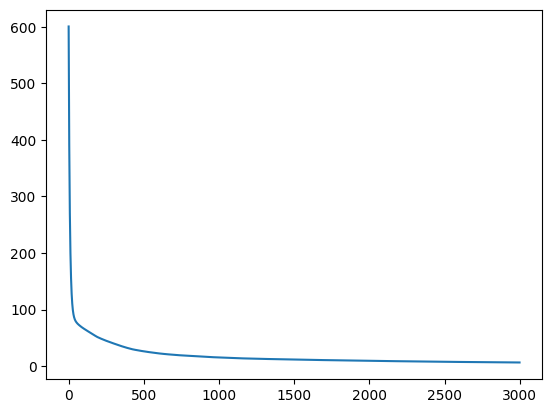

In [ ]:
params = create_layers(key, layer_sizes) # reset the model params, copied from above
params = train_model(params, inputs, targets, 0.0001)

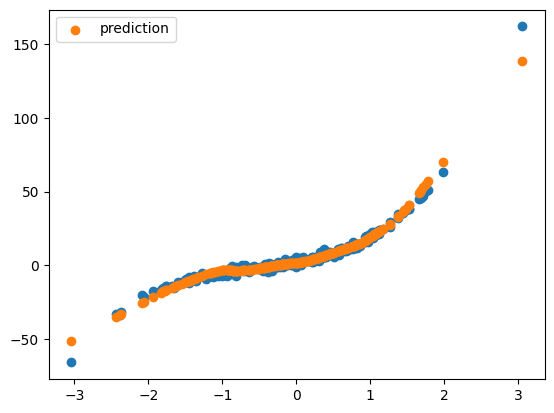

In [ ]:
plt.scatter(inputs,targets)
plt.scatter(inputs, predict(params, inputs), label='prediction')
plt.legend()

# NNX

https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/getting_started_with_jax_for_AI.ipynb